Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


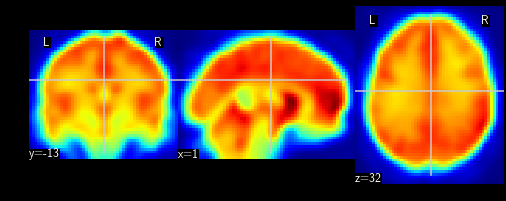

In [10]:
# coding: utf-8

# In[1]:


import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
import nitime

# Import the time-series objects:
from nitime.timeseries import TimeSeries

# Import the analysis objects:
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer

def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

def innerProduct(x, y):
    result = tf.reduce_sum(tf.multiply(x, y))
    return result

def compute_step_size(n_omega, grad):
    result = -innerProduct(n_omega,grad)/(innerProduct(n_omega, n_omega))
    return result

def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt3"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)

def get_mask(data, observed_ratio):
    
    if len(data.shape) == 3:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2]) < observed_ratio).astype('int') 
    elif len(data.shape) == 4:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2], data.shape[3]) < observed_ratio).astype('int') 
    elif len(data.shape) == 2:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1]) < observed_ratio).astype('int') 
    
    return mask_indices

def get_z_score_mask(data, z_score):
    
    z_scored_data = stats.zscore(data)
    
    if len(data.shape) == 3:
        mask_indices = (z_scored_data(data.shape[0],data.shape[1],data.shape[2]) < z_score).astype('int') 
    elif len(data.shape) == 4:
        mask_indices = (z_scored_data(data.shape[0],data.shape[1],data.shape[2], data.shape[3]) < z_score).astype('int') 
    elif len(data.shape) == 2:
        mask_indices = (z_scored_data(data.shape[0],data.shape[1]) < z_score).astype('int') 
    
    return mask_indices

x_true_img = np.array(x_true_org.get_data())
norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)

ground_truth_z_score = stats.zscore(x_true_img)

mask_img = compute_epi_mask(x_true_org,lower_cutoff=0.03,upper_cutoff=0.97)
mask_img_data = np.array(mask_img.get_data())

observed_ratio = 0.2
missing_ratio = 1 - observed_ratio

mask_indices = (ground_truth_z_score < 2).astype('int') 
epi_mask = copy.deepcopy(mask_img_data)
    
mask_indices[epi_mask==0] = 1
mask_indices_count = np.count_nonzero(mask_indices==0)
epi_mask_count = np.count_nonzero(epi_mask==0)*144
effective_missing_ratio = float(mask_indices_count)/float(epi_mask_count)

ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0

x_init = copy.deepcopy(x_train)


ground_truth = copy.deepcopy(x_true_img)
ground_truth_x = copy.deepcopy(x_true_img)
a_omega = copy.deepcopy(ground_truth)
a_omega[mask_indices==0] = 0.0

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0


x_init1 = np.random.rand(53, 63, 46, 144).astype('float32')
norm_ground_x_init1 = np.linalg.norm(x_init1)
x_init1 = x_true_img * (1./norm_ground_x_init1)


folder = '/work/rs1/'
x_org = mt.reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,1)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)
ten_ones = np.ones_like(mask_indices)

x_reconstr_init = mt.reconstruct2(x_init1,ground_truth, mask_indices)


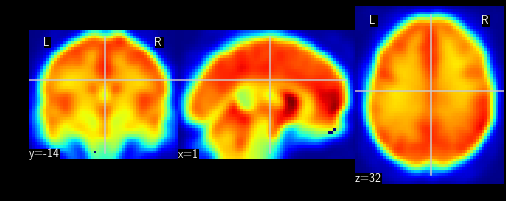

In [12]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

x_miss = image.index_img(x_miss_img,100)
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 


In [ ]:

images_folder = "/work/scratch/tt3"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

In [13]:
effective_missing_ratio

0.0005469749010532822

In [14]:
epi_mask_count

13150512

In [15]:
mask_indices_count

7193

In [12]:
epi_mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [14]:
epi_mask[26, 23, 33]

1